In [1]:
import pandas_profiling
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# 1, 2
df = pd.read_csv('household_power_consumption.csv')

In [3]:
# 3
print(f'We have {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

We have 2075259 rows and 9 columns


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
for column in df.columns[2:]:
    df[column][df[column] == '?'] = np.NaN
    df[column] = df[column].astype(float)
df['active_energy_consumed'] = df['Global_active_power'] * 1000 / 60 - df['Sub_metering_1'] - df['Sub_metering_2'] - df['Sub_metering_3']

In [5]:
# 4
# print number of rows with missing values, analyze which columns have the biggest number of missing values
df.isna().sum()

Date                          0
Time                          0
Global_active_power       25979
Global_reactive_power     25979
Voltage                   25979
Global_intensity          25979
Sub_metering_1            25979
Sub_metering_2            25979
Sub_metering_3            25979
active_energy_consumed    25979
dtype: int64

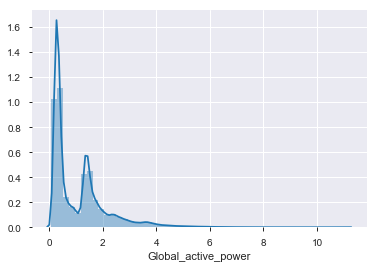

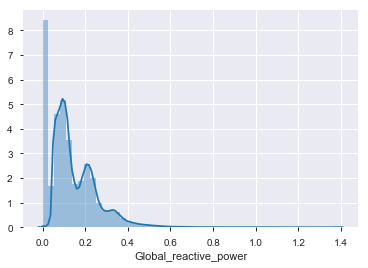

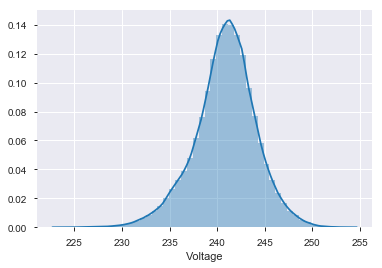

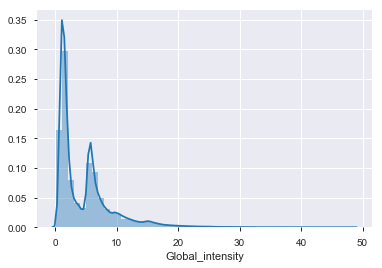

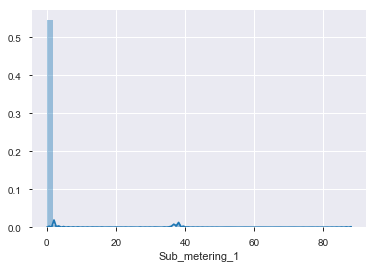

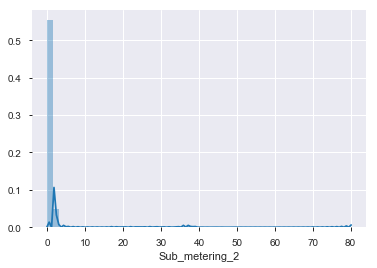

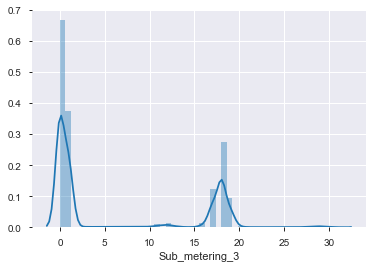

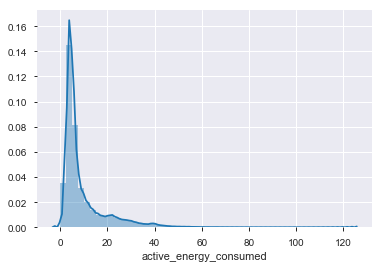

In [6]:
# 5
df.interpolate(inplace=True)
for c in df.columns[2:]:
    plt.figure(figsize=((6,4)))
    sns.distplot(df[c])

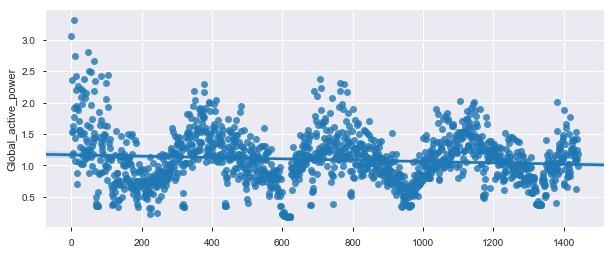

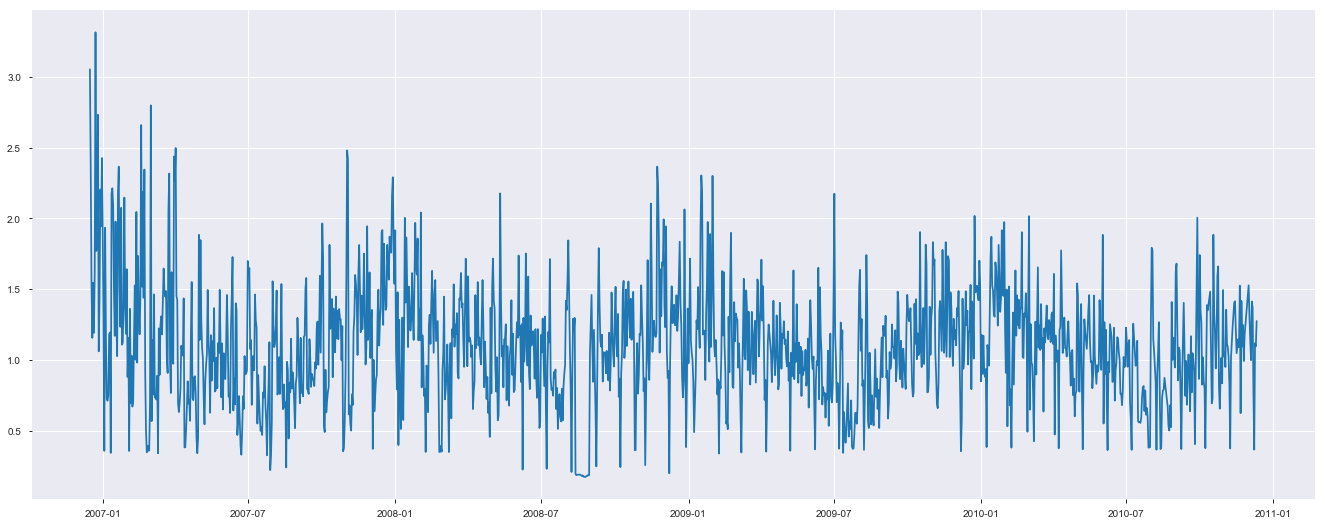

In [7]:
# 6
group = df.groupby(by='Date', sort=False).aggregate(np.mean)

plt.figure(figsize=(10, 4))
sns.regplot(x=np.arange(group.shape[0]), y=group['Global_active_power'])

group['date'] = group.index
group['date'] = pd.to_datetime(group['date'])
group = group.set_index('date')

plt.figure(figsize=(23, 9))
sns.lineplot(data=group['Global_active_power'])

In [8]:
# 7
two_days = df[(df['Date'] == '1/2/2008') | (df['Date'] == '2/2/2008')].reset_index().drop(columns=['index'])
two_days.head(7)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,active_energy_consumed
0,1/2/2008,00:00:00,2.268,0.184,239.79,9.4,0.0,0.0,18.0,19.800000
1,1/2/2008,00:01:00,2.210,0.188,240.70,9.2,0.0,0.0,17.0,19.833333
2,1/2/2008,00:02:00,2.270,0.184,239.96,9.4,0.0,0.0,18.0,19.833333
3,1/2/2008,00:03:00,2.238,0.182,239.63,9.4,0.0,0.0,18.0,19.300000
4,1/2/2008,00:04:00,2.204,0.184,240.11,9.2,0.0,0.0,17.0,19.733333
5,1/2/2008,00:05:00,2.272,0.186,240.49,9.4,0.0,0.0,18.0,19.866667
6,1/2/2008,00:06:00,2.272,0.186,240.50,9.4,0.0,0.0,18.0,19.866667


In [9]:
def plot_7(variable):
    plt.figure(figsize=(12, 6))
    return  sns.lineplot(x=np.arange(two_days.shape[0]), y=two_days[variable])

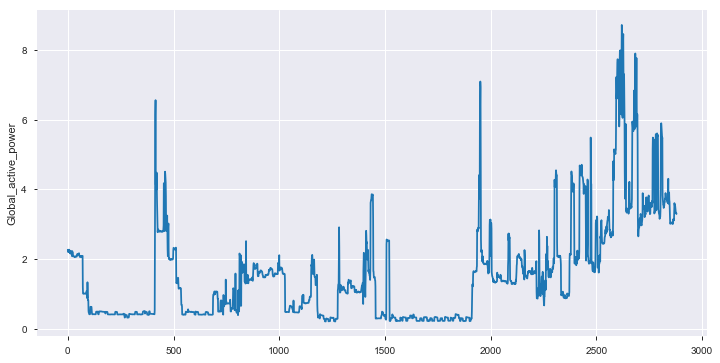

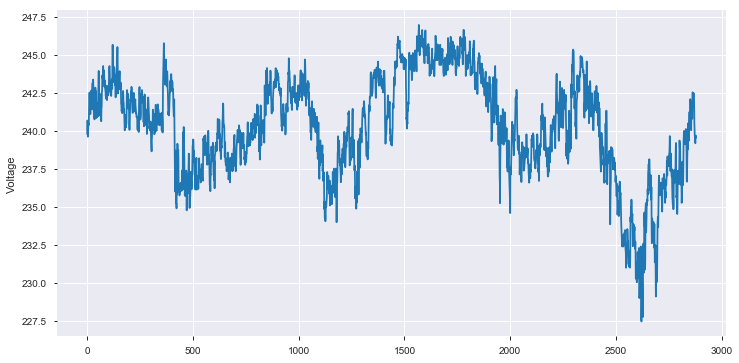

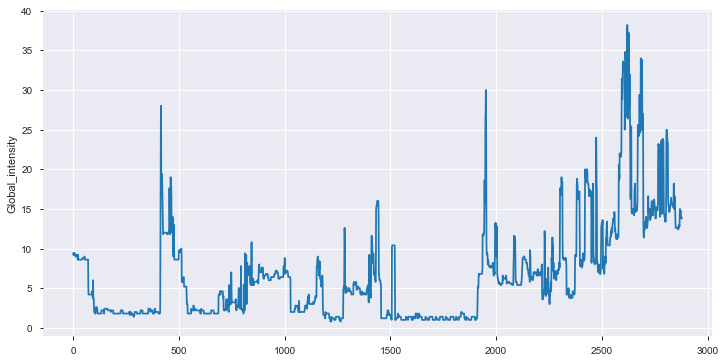

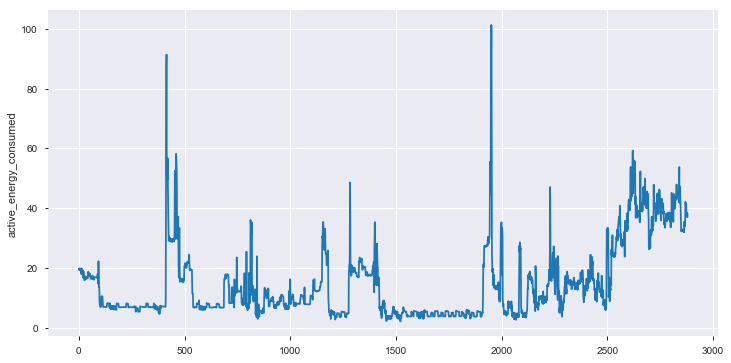

In [10]:
columns = ['Global_active_power', 'Voltage', 'Global_intensity', 'active_energy_consumed']
for column in columns:
    two_days[column]
    plot_7(column)

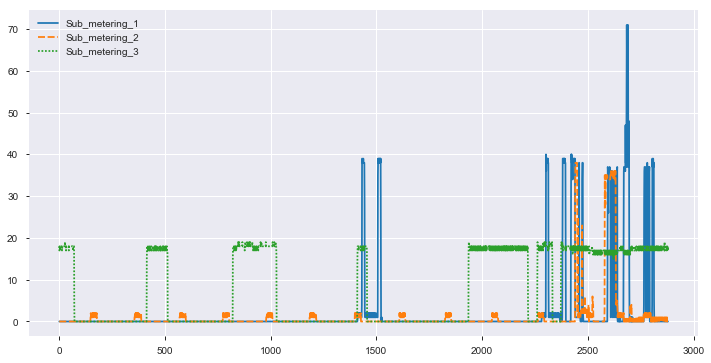

In [11]:
plt.figure(figsize=(12, 6));
sns.lineplot(data=two_days[['Sub_metering_1', 'Sub_metering_2','Sub_metering_3']]);

In [12]:
from collections import Counter
# Outlier detection 

def detect_outliers(train_data,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(train_data[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(train_data[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = train_data[(train_data[col] < Q1 - outlier_step) | (train_data[col] > Q3 + outlier_step )].Date
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers 

In [13]:
print('Dates with abnormal voltage or current - ', len(detect_outliers(df, 1, ['Global_intensity', 'Voltage'])))

Dates with abnormal voltage or current -  1291


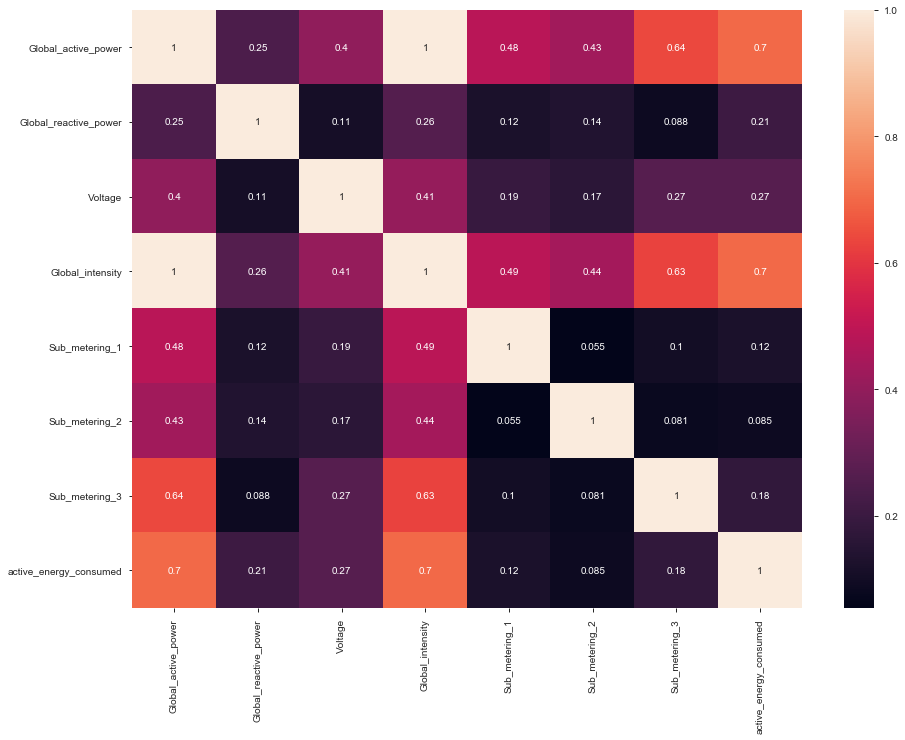

<Figure size 1080x792 with 0 Axes>

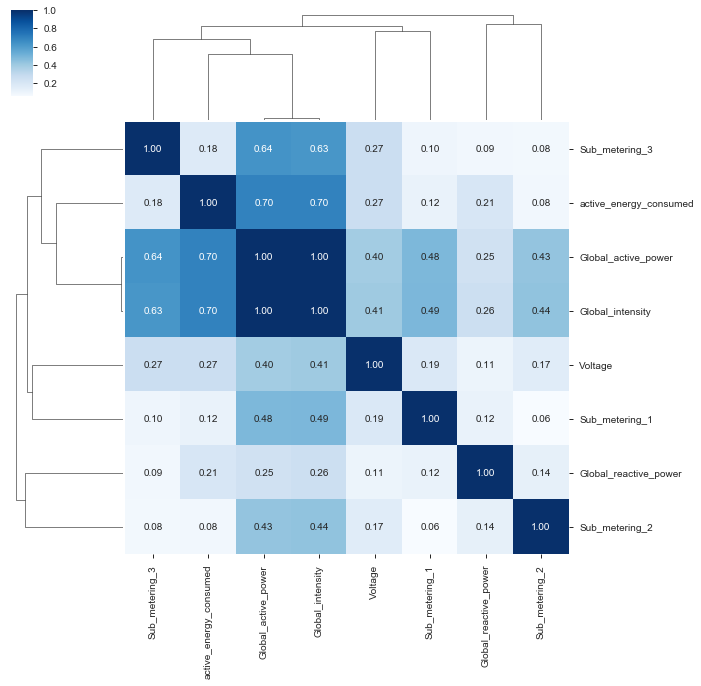

In [14]:
# 9
plt.figure(figsize=(15, 11));
sns.heatmap(df.corr().abs(), annot=True);

plt.figure(figsize=(15, 11));
sns.clustermap(data = df.corr().abs(),annot=True, fmt = ".2f", cmap = 'Blues');

Gloval active power and global intensity are very correlated, probably meaning that one directly affects the other.

In [15]:
# 10
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,active_energy_consumed
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


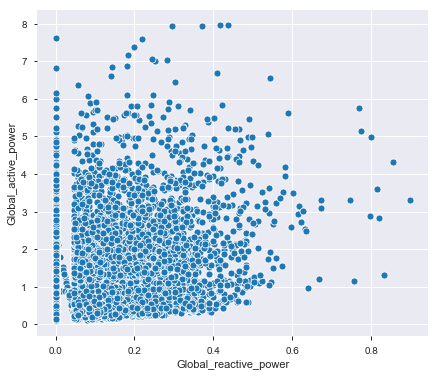

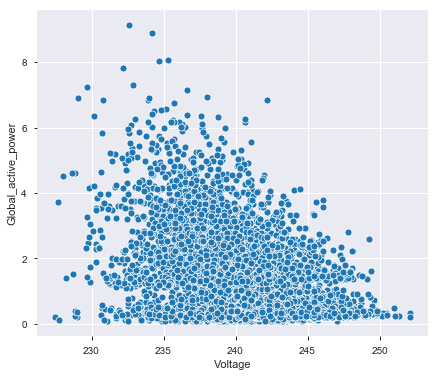

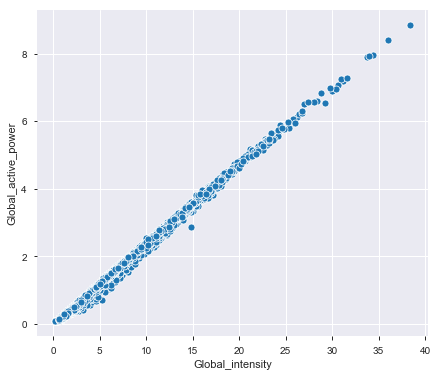

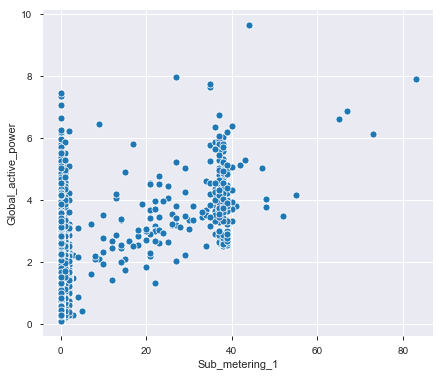

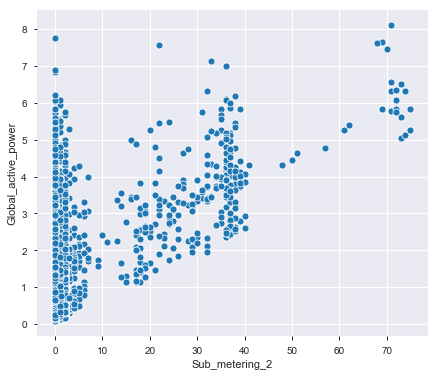

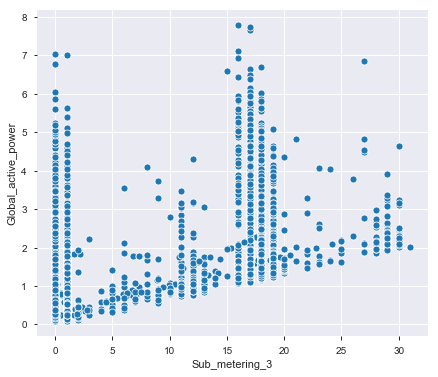

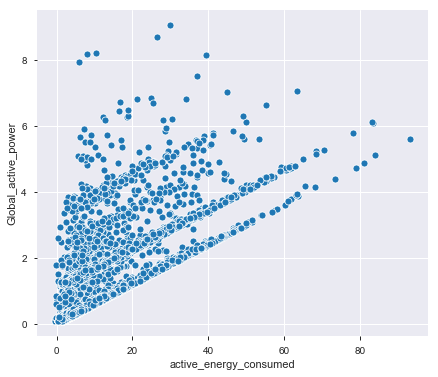

In [16]:
for col in df.columns[3:]:
    plt.figure(figsize=(7, 6))
    x_y = df[['Global_active_power', col]].sample(10000)
    sns.scatterplot(x = x_y[col], y = x_y['Global_active_power'])

In [19]:
NUM_PERIODS = 5

date_features = pd.DataFrame(df['Date'].str.split('/').tolist(), columns=['Day','Month', 'Year'], dtype=float)
time_features = pd.DataFrame(df['Time'].str.split(':').tolist(), columns=['Hours', 'Minutes', 'Sec'], dtype=float).drop(columns=['Sec'])

# Days
date_features['Day_sin'] = np.sin(2 * np.pi * date_features['Day'] / date_features['Day'].max())
date_features['Day_cos'] = np.cos(2 * np.pi * date_features['Day'] / date_features['Day'].max())
# Months
date_features['Month_sin'] = np.sin(2 * np.pi * date_features['Month'] / date_features['Month'].max())
date_features['Month_cos'] = np.cos(2 * np.pi * date_features['Month'] / date_features['Month'].max())
# Years
date_features['Year'] = date_features['Year'] - date_features['Year'].min()
# Hours
time_features['Hours_sin'] = np.sin(2 * np.pi * time_features['Hours'] / time_features['Hours'].max())
time_features['Hours_cos'] = np.cos(2 * np.pi * time_features['Hours'] / time_features['Hours'].max())
# Minutes
time_features['Minutes_sin'] = np.sin(2 * np.pi * time_features['Minutes'] / time_features['Minutes'].max())
time_features['Minutes_cos'] = np.cos(2 * np.pi * time_features['Minutes'] / time_features['Minutes'].max())

generated = date_features.merge(time_features, left_index=True, right_index=True).drop(columns=['Day', 'Month', 'Hours', 'Minutes'])

new_df = df.drop(columns=['Date', 'Time'])
for i in range(1, NUM_PERIODS + 1): 
    new_df[f'GAP_{i}'] = new_df['Global_active_power'].shift(periods=i)
new_df.dropna(inplace=True)

scaler = StandardScaler().fit(new_df)
new_df = pd.DataFrame(scaler.transform(new_df), columns=new_df.columns)
new_df = new_df.merge(generated, left_index=True, right_index=True)

In [20]:
new_df.head()

In [21]:
X, y = new_df.drop(columns=['Global_active_power']), new_df['Global_active_power']

In [22]:
report = new_df.profile_report()